In [ ]:
! pip install pygam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.2/522.2 kB 33.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 59.9 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.4
    Uninstalling numpy-1.22.4:
      Successfully uninstalled numpy-1.22.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.56.4 requires numpy<1.24,>=1.18, but you have numpy 1.25.0 which is incompatible.
tensorflow 2.12.0 requires numpy<1.24,>=1.22, but you have numpy 1.25.0 which is incompatible.


In [ ]:
! pip install numpy

In [ ]:
#from pygam import LinearGAM
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import re
import random
from itertools import chain
import csv


sns.set(style="white", color_codes=True)

## Set up dependencies and data

Run the cell below to fetch the recurrent neural network codebase we've designed for this assignment.

It will leave the files in a directory called `rnn` (check in the sidebar after you've run the command).

In [ ]:
%%bash
git clone https://github.com/scaperex/neural-complexity.git rnn
mkdir -p rnn/data/ptb

Cloning into 'rnn'...


## Mount Google Drive

We'll save your corpus data, model checkpoints, and output to Google Drive for safekeeping.

Follow the instructions in the output of this command to link your Drive account.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
GDRIVE_DIR = "/content/gdrive/My Drive/096222_project_surprisals_and_rts"
!mkdir -p "$GDRIVE_DIR"
!mkdir -p "$GDRIVE_DIR/corpus_data"

## Upload corpus files for LM training

Here we upload the Penn Treebank corpus files  to the `rnn/data/ptb` folder.
Your files should be named:

- `ptb_tok_train.txt`
- `ptb_tok_dev.txt`

In [ ]:
!wget -qO rnn/data/ptb/ptb_tok_train.txt https://gist.githubusercontent.com/omershubi/cdd4231472d6188f03ab21e2b2729fee/raw/e1b4c764561fd038470830534baaa220b0eb4c6d/ptb_tok_train.txt
!wget -qO rnn/data/ptb/ptb_tok_dev.txt https://gist.githubusercontent.com/omershubi/31eff71b74dfb8cfe93d1a9acf8ab523/raw/094d3094b06beb92cd7fd0496710cf43273f8c64/ptb_tok_dev.txt
!cp rnn/data/ptb/* "$GDRIVE_DIR/corpus_data/"

# Functions:


In [ ]:
sprt = pd.read_csv('https://gist.githubusercontent.com/omershubi/01b55eab89b81dc882055e0d27d61016/raw/046dbb7f0586b5dc1a368ee882f2cb923caad3df/brown-spr-data-for-pset.csv', index_col=0).sort_values(by='code')

In [ ]:
def plot_relation(data, x, y, title):
  g = sns.jointplot(data=data, x=x,y=y, kind='reg')
  g.fig.suptitle(title)
  # We're going to make the regression line red so it's easier to see
  regline = g.ax_joint.get_lines()[0]
  regline.set_color('red')

In [ ]:
def find_diff_sentences(data,orig_surp, surp1,surp2):
  data['diff'] = abs(data[surp1]-data[surp2])
  max_diff = data.sort_values('diff',ascending=False).head(5)
  sents_ids  = max_diff['sentid'].values
  word_indx  = max_diff['sentid'].index.values
  for sen_id, word_id in zip(sents_ids, word_indx):
    original = orig_surp[orig_surp['sentid']==sen_id]

    if 'word_ngram' in data.keys().values:
      temp = data.iloc[word_id].drop(['diff', surp2, 'mean_rt', 'word_ngram'])
    else:
      temp = data.iloc[word_id].drop(['diff', surp2, 'mean_rt'])
    sen = []
    for i, row in original.iterrows():
      if row.equals(temp):
        sen.append('*'+row['word']+"*")
      else:
        sen.append(row['word'])
    sen = ' '.join(sen)
    print('##########')
    print(sen)


In [ ]:
def add_next_rt(data):
  next_col = pd.concat([data['mean_rt'], pd.Series([0])], ignore_index=True)
  next_col = next_col.iloc[1:]
  next_col = next_col.set_axis(list(range(len(data))))
  data['next_rt'] = next_col
  return data

In [ ]:
def clean_data(rt_data: pd.DataFrame, surprs_data: pd.DataFrame) -> pd.DataFrame:
  temp_words = rt_data['word']
  ### Clean data:
  surprs_data.drop(surprs_data.index[(surprs_data["word"] == "</s>")], axis=0, inplace=True)
  surprs_data.drop(surprs_data.index[(surprs_data["word"] == "<unk>")], axis=0, inplace=True)
  surprs_data.drop(surprs_data.index[(surprs_data["word"] == "--")], axis=0, inplace=True)
  surprs_data = surprs_data.reset_index(drop = True)
  ### Groupby:
  grouped_rt_data = rt_data.groupby(by=['code', 'text_id', 'text_pos'], as_index=False).agg({'word':'first', 'time':'mean'})
  grouped_rt_data = grouped_rt_data.rename(columns={'time':'mean_rt'})
  grouped_rt_data["word"] = grouped_rt_data["word"].apply(lambda t: t.split(" "))
  grouped_rt_data = grouped_rt_data.explode('word')
  grouped_rt_data = grouped_rt_data.reset_index(drop= True)
  return grouped_rt_data, surprs_data


def harmonize(rt_data: pd.DataFrame, surprs_data: pd.DataFrame) -> pd.DataFrame:
    ### Merge:
    index_rt, index_surp = 0, 0
    flag = 0
    len_rt, len_surpr = len(rt_data.index), len(surprs_data)
    df = pd.DataFrame(columns=['word', 'sentid',	'sentpos',	'wlen'	 ,'surprisal', 'mean_rt'])
    while(index_rt < len_rt and index_surp < len_surpr):
      if surprs_data.at[index_surp, 'word'] in rt_data.at[index_rt, 'word']:
        df.loc[df.shape[0]] = [surprs_data['word'][index_surp], surprs_data['sentid'][index_surp], surprs_data['sentpos'][index_surp], surprs_data['wlen'][index_surp], surprs_data['surp'][index_surp], rt_data['mean_rt'][index_rt]]
        index_rt += 1
        index_surp += 1
      else:
        index_rt += 1
    return df

In [ ]:
def split_sentences(book):
  split_book, temp, sent_book = [], [], []
  for l in book:
    if l != '\n':
      temp.append(l[:-1])
    else:
      split_book.append(' '.join(temp))
      temp = []
  for p in split_book:
    sent_book.extend(re.split(r'[.?!]\s*', p.lower()))

  return list(filter(None, sent_book))

In [ ]:
def create_harmonize_limited2(sprt, rnn_surprisals, harmonized_df, book):
  sprt_grouped, surp_clean = clean_data(sprt, rnn_surprisals)
  harmonized = harmonize(sprt_grouped, surp_clean)
  harmonized['mean_rt'] = harmonized_df['mean_rt']
  harmonized['wiki_surp'] = harmonized_df['wiki_surp']
  harmonized.rename(columns={'surprisal': f'{book}_surp'}, inplace=True)
  limited = harmonized.merge(harmonized_df, on=['word',	'sentid',	'sentpos',	'wlen'], how='inner')
  limited.rename(columns = {'surprisal':f'{book}_surp', 'surp_y':'wiki_surp','mean_rt_x': 'mean_rt'}, inplace = True)
  limited.drop(columns=['Unnamed: 0', 'mean_rt_y'], inplace = True)
  return harmonized, limited

In [ ]:
def create_harmonize_limited(sprt, rnn_surprisals, harmonized_df, book):
  sprt_grouped, surp_clean = clean_data(sprt, rnn_surprisals)
  harmonized = harmonize(sprt_grouped, surp_clean)
  limited = harmonized.merge(harmonized_df, on=['word',	'sentid',	'sentpos',	'wlen'], how='inner')
  limited.rename(columns = {'surprisal':f'{book}_surp', 'surprisal_y':'wiki_surp','mean_rt_x': 'mean_rt'}, inplace = True)
  limited.drop(columns=['Unnamed: 0', 'mean_rt_y'], inplace = True)
  harmonized.rename(columns = {'surprisal':f'{book}_surp'}, inplace = True)
  return harmonized, limited

In [ ]:
def plot_all(limited, next_limited, surp, rt, book):
  plot_relation(limited, surp, rt, f'surprise-RT {book} relation')
  plot_relation(next_limited, surp, rt, f'surprise-next RT {book} relation')
  plot_relation(limited, surp, 'wiki_surp', f'surprise {book}-Wikipedia relation')

# Part 1: Structudered Task -  Recurrent neural network modeling



## Train model

Now we're ready to begin training the model. The below command will launch the neural network optimization procedure, and progressively save checkpoints to the Google Drive you've just mounted. The neural network train for 40 epochs (1 epoch = 1 loop through the training dataset), which should take approximately **2 hours**.

Checkpoints will be saved each time the validation loss improves, and named `ptb_model.pt`. Watch the output of the command below to see how the model's train and validation perplexity improve over time.

In [ ]:
!cd rnn && python main.py --cuda --model_file "$GDRIVE_DIR/ptb_model.pt" \
    --epochs 40 \
    --vocab_file "$GDRIVE_DIR/ptb_vocab.txt" \
    --tied --data_dir "$GDRIVE_DIR/corpus_data" --trainfname ptb_tok_train.txt --validfname ptb_tok_dev.txt

Libraries loaded
| epoch   1 |   200/ 1422 batches | lr 20.00 | ms/batch 23.93 | loss  6.73 | ppl   837.07
| epoch   1 |   400/ 1422 batches | lr 20.00 | ms/batch 19.16 | loss  6.04 | ppl   421.34
| epoch   1 |   600/ 1422 batches | lr 20.00 | ms/batch 12.10 | loss  5.90 | ppl   365.32
| epoch   1 |   800/ 1422 batches | lr 20.00 | ms/batch 12.14 | loss  5.83 | ppl   341.77
| epoch   1 |  1000/ 1422 batches | lr 20.00 | ms/batch 12.16 | loss  5.84 | ppl   342.74
| epoch   1 |  1200/ 1422 batches | lr 20.00 | ms/batch 12.24 | loss  5.78 | ppl   324.46
| epoch   1 |  1400/ 1422 batches | lr 20.00 | ms/batch 12.31 | loss  5.82 | ppl   336.83
-----------------------------------------------------------------------------------------
| end of epoch   1 | time: 21.28s | lr: 20.00000000 | valid ppl   270.29
-----------------------------------------------------------------------------------------
| epoch   2 |   200/ 1422 batches | lr 20.00 | ms/batch 12.38 | loss  5.83 | ppl   339.01
| epoch   

## Compute surprisals

Now we'll compute model surprisals for the text data in `brown.txt` (already downloaded for you). This will output a file called `rnn_surprisals.tsv` to your Google Drive, which you'll use in the next steps of the analysis.

We'll load the checkpoint and use it to extract per-token surprisal estimates.

In [ ]:
checkpoint_to_use = f"{GDRIVE_DIR}/ptb_model.pt"
!cd rnn && python main.py --cuda --model_file "$checkpoint_to_use" \
    --vocab_file "$GDRIVE_DIR/ptb_vocab.txt" --data_dir './data' \
    --testfname 'brown.txt' --test --words --nopp > "$GDRIVE_DIR/rnn_surprisals.tsv"

Libraries loaded
Using beamsize: 23757


In [ ]:
rnn_surprisals = pd.read_csv(f'{GDRIVE_DIR}/rnn_surprisals.tsv',sep=' ')
rnn_surprisals

,word,sentid,sentpos,wlen,surp,entropy,entred
0,In,0,0,2,5.506053,9.515585,0.000000
1,<unk>,0,1,5,6.578504,7.866125,1.649460
2,County,0,2,6,12.514248,6.056062,1.810063
3,<unk>,0,3,5,7.031470,8.524199,0.000000
4,near,0,4,4,13.308077,8.640187,0.000000
...,...,...,...,...,...,...,...
7229,as,363,15,2,6.248776,4.505761,3.256542
7230,a,363,16,1,2.861911,7.777086,0.000000
7231,leader,363,17,6,11.365563,11.206182,0.000000
7232,and,363,18,3,6.632089,5.544580,5.661602


## Harmonize RNN surprisal and RT data

Load and align the reading times with the n-gram model surprisals.
You may load the harmonized csv from Homework 2, or align it again.

Finallyy, align the RNN model-derived surprisal values with human reading times. The harmonize function you wrote in Homework 2 may be helpful here too.

Note, modifications may be required as the tokenization is not necessarily the same as the n-gram model.


In [ ]:
ngram_surprisals = pd.read_csv(f'{GDRIVE_DIR}/harmonized_ngram.csv')
ngram_surprisals

,Unnamed: 0,word,mean_rt,surprisal
0,0,In,380.275294,4.57937
1,1,County,296.042941,12.65410
2,2,near,403.553529,12.22380
3,3,the,306.075882,1.98095
4,4,River,289.048235,15.70900
...,...,...,...,...
5496,5496,failed,292.772500,8.25341
5497,5497,as,284.470833,9.42416
5498,5498,a,282.622083,3.23962
5499,5499,leader,279.445417,12.81650


### Clean data to match the ngram surprisal data

In [ ]:
rnn_surprisals.drop(rnn_surprisals.index[(rnn_surprisals["word"] == "</s>")], axis=0, inplace=True)
rnn_surprisals.drop(rnn_surprisals.index[(rnn_surprisals["word"] == "<unk>")], axis=0, inplace=True)
rnn_surprisals.drop(rnn_surprisals.index[(rnn_surprisals["word"] == "--")], axis=0, inplace=True)
rnn_surprisals = rnn_surprisals.reset_index(drop = True)
rnn_surprisals

,word,sentid,sentpos,wlen,surp,entropy,entred
0,In,0,0,2,5.506053,9.515585,0.000000
1,County,0,2,6,12.514248,6.056062,1.810063
2,near,0,4,4,13.308077,8.640187,0.000000
3,the,0,5,3,1.662673,7.870934,0.769253
4,River,0,6,5,17.830992,11.037002,0.000000
...,...,...,...,...,...,...,...
5496,failed,363,14,6,9.048445,7.762303,0.462083
5497,as,363,15,2,6.248776,4.505761,3.256542
5498,a,363,16,1,2.861911,7.777086,0.000000
5499,leader,363,17,6,11.365563,11.206182,0.000000


In [ ]:
rnn_surprisals['mean_rt'] = ngram_surprisals['mean_rt']
rnn_surprisals['word_ngram'] = ngram_surprisals['word']

### Examine relation between RNN model and N-Gram model:

In [ ]:
corr_rnn = rnn_surprisals['mean_rt'].corr(rnn_surprisals['surp'])
corr_ngram = ngram_surprisals['mean_rt'].corr(ngram_surprisals['surprisal'])

print(f'The correlation achived with the RNN model: {corr_rnn}. The correlation achived with the N-Gram model: {corr_ngram}')

The correlation achived with the RNN model: 0.18811630616483854. The correlation achived with the N-Gram model: 0.18146351844413286


We can observe that both model has psitive association between reading time and surprise, but not very strongly. The RNN correlation is slightly better.

In [ ]:
combined_data = rnn_surprisals.copy()
combined_data['surp_ngram'] = ngram_surprisals['surprisal']
combined_data.rename(columns ={'surp':'surp_rnn'}, inplace = True)
combined_data['diff'] = combined_data['surp_rnn']-combined_data['surp_ngram']


In [ ]:
combined_data['surp_ngram'].corr(combined_data['surp_rnn'])

0.8949079361710894

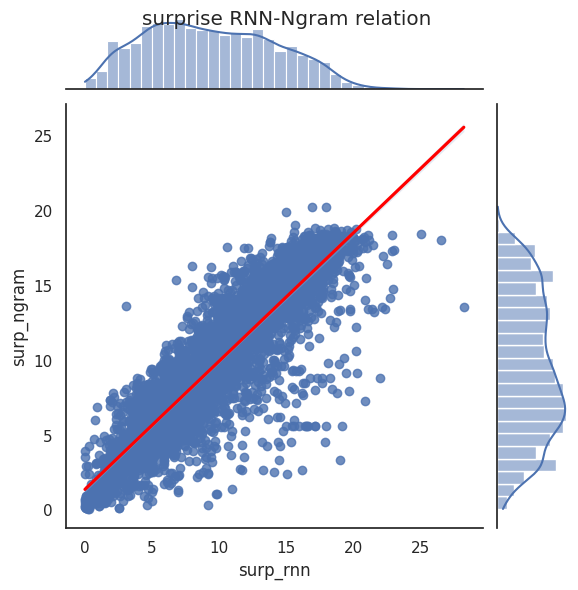

In [ ]:
plot_relation(combined_data,'surp_rnn', 'surp_ngram', 'surprise RNN-Ngram relation')

Overall, we can see that the models are generally outputing the same results.
When examining the surprisial with high values, we can see in the graph that the RNN model gave higher surprisal rate than then n-gram model. We will examine this phenomenon:

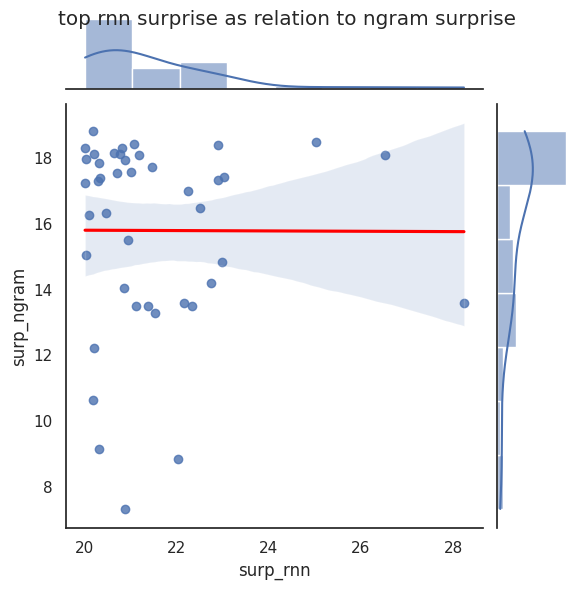

In [ ]:
plot_relation(combined_data[combined_data['surp_rnn'] > 20],'surp_rnn', 'surp_ngram' ,'top rnn surprise as relation to ngram surprise')

In this graph we can see that the regression line is very far from x=y like we saw in the previous graph for all the data. Also we can see that most values of the RNN model have a surprisal value that is higher in 6 to 8 miliseconds than the n-gram model.


In [ ]:
min_diff = combined_data.sort_values('diff').head(5)
max_diff = combined_data.sort_values('diff',ascending=False).head(5)
rnn_surprisals_tmp = pd.read_csv(f'{GDRIVE_DIR}/rnn_surprisals.tsv',sep=' ')
rnn_surprisals_tmp.rename(columns ={'surp':'surp_rnn'}, inplace = True)

In [ ]:
find_diff_sentences(combined_data, rnn_surprisals_tmp, 'surp_rnn', 'surp_ngram')

##########
Down in <unk> New <unk> was a flier in the right place at the right <unk> Robert S. <unk> a native New <unk> had been a World War *I* flying <unk> <unk> and one of the original planners of the Concord <unk>
##########
She was the *John* <unk> one of those Atlantic <unk> that had sailed to <unk> to bring <unk> <unk> and bullets to the U.S. <unk> Air <unk> to Field <unk> <unk> <unk> Army then racing up the <unk> of the <unk> of Italy in that early December of <unk>
##########
A ripple ran through the muscles of his <unk> but he kept control upon his <unk> <unk> must be some water under <unk> *He* tilted his <unk> face toward the dry bed of the <unk> <unk> can get it if we <unk> he said <unk> <unk> add fever to our <unk> She <unk> <unk> do you want to see if I can stand <unk> <unk> <unk> can <unk> <unk> he <unk>
##########
<unk> been out with Pete *the* night before and her gay <unk> about their date <unk> my mood a <unk>
##########
I state <unk> that we shall under no circumst

We will examining the difference between the models in order to try and understand the different results we are recieving.

RNN models excel at text tasks because they possess the ability to retain information from previous words in a sentence, enabling them to capture contextual dependencies and produce more coherent and accurate predictions.

Given that, because surprisal is based on the context of the sentence, the RNN model has better understanding of the context than the N-Gram model. The N-Gram model only views the last N words given that the context it uses in order to calculate the surprisal is limited.

Also the RNN model can be better at learning more complex relations, and even syntactic relations, again because of it's ability to retain information from previous parts of the sentence, unlike the N-Gram model which is a much simpilar model that does not excel in such relations.

### Spillover Effect:

In [ ]:
prob_ngram = 1/np.exp(combined_data.surp_ngram)
prob_rnn = 1/np.exp(combined_data.surp_rnn)

combined_data['prob_ngram'] = prob_ngram
combined_data['prob_rnn'] = prob_rnn

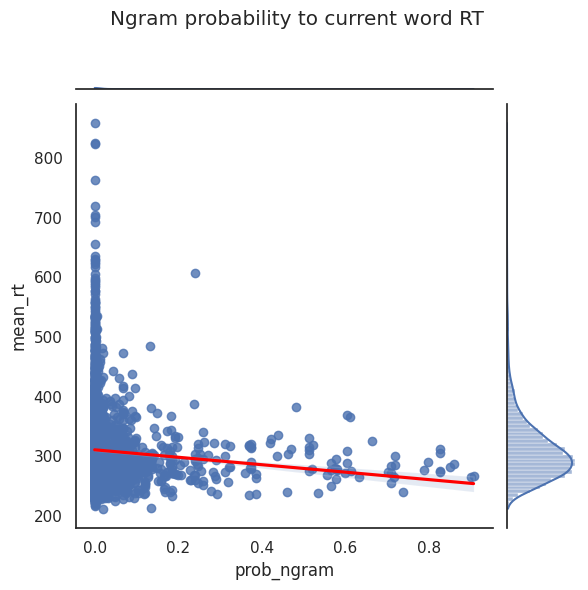

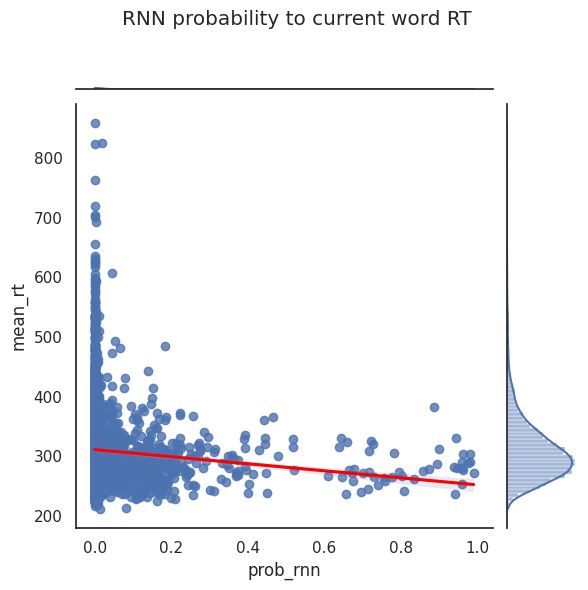

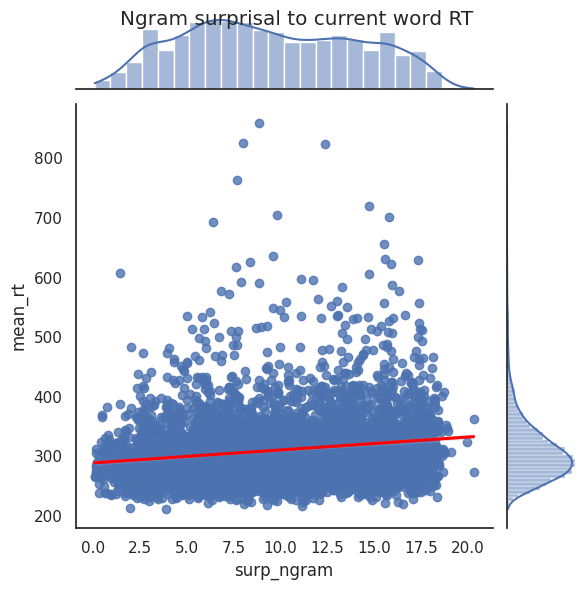

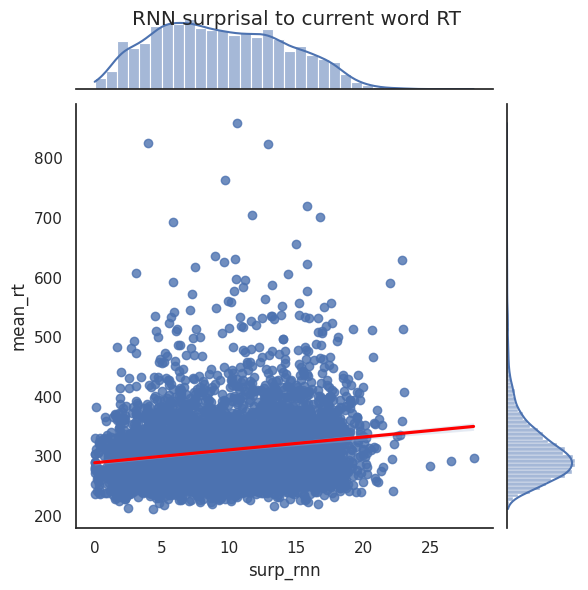

In [ ]:
# current word
plot_relation(combined_data,'prob_ngram', 'mean_rt', 'Ngram probability to current word RT')
plot_relation(combined_data,'prob_rnn', 'mean_rt', 'RNN probability to current word RT')

plot_relation(combined_data,'surp_ngram', 'mean_rt', 'Ngram surprisal to current word RT')
plot_relation(combined_data,'surp_rnn', 'mean_rt', 'RNN surprisal to current word RT')

In [ ]:

combined_data = add_next_rt(combined_data)

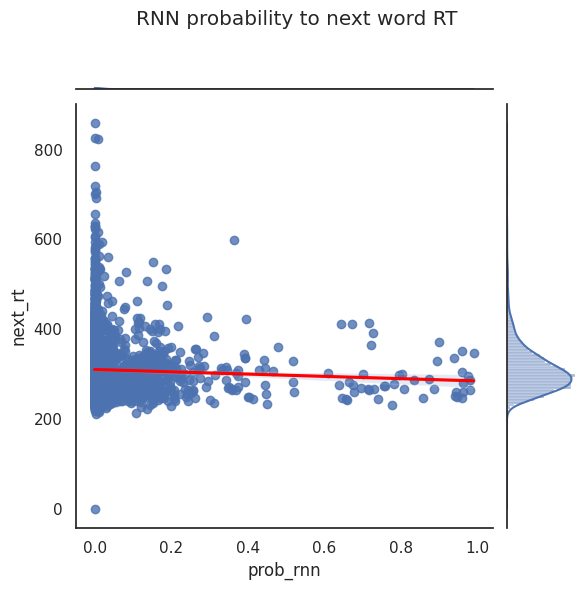

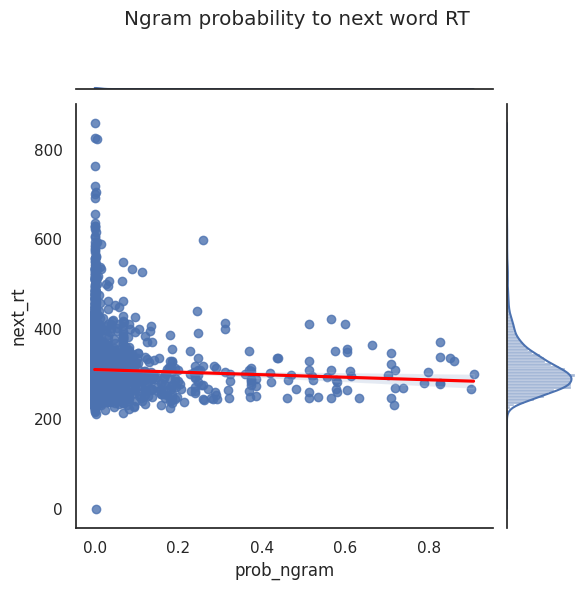

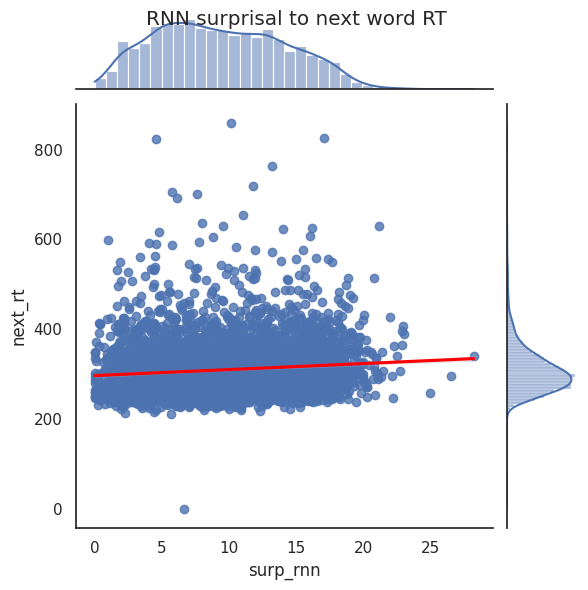

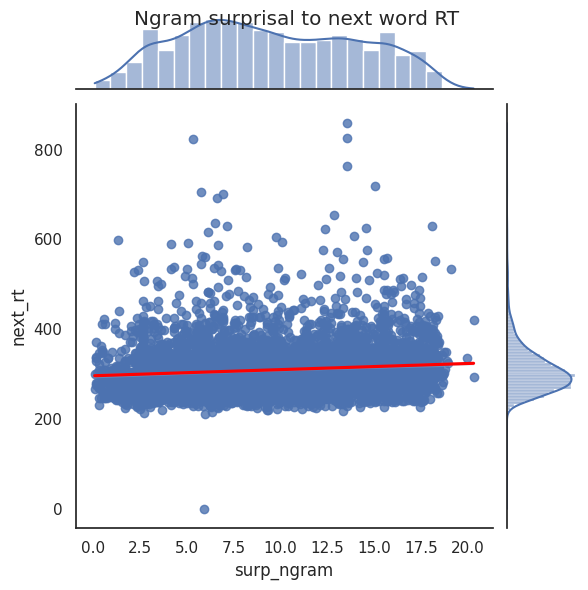

In [ ]:
# next word
plot_relation(combined_data,'prob_rnn', 'next_rt', 'RNN probability to next word RT')
plot_relation(combined_data,'prob_ngram', 'next_rt', 'Ngram probability to next word RT')

plot_relation(combined_data,'surp_rnn', 'next_rt', 'RNN surprisal to next word RT')
plot_relation(combined_data,'surp_ngram', 'next_rt', 'Ngram surprisal to next word RT')

 We examined the relation between the current word probability on both models on the reading time of current word and next word. We can observe that the spillover effect is smaller than the effect on current word, like the regression line shows: as the probability grows, the reading time of the next word decreases slightly, and the reading time of the current word decreases more significantly.
 We would like to state that we removed from the data the unknown words in order to be able to match between the reading time of the models and the surprisal. In some cases, the real next word could be an unknown word, and we are missing it's spillover effect.

# Part 2: Semi Structed Task

## 1. Fit and plot the RT surprisal curve usinga General Additive Model (GAM)

In this part we will be working with GAM models. GAM models come to improve linear models, by understanding that the effect of each feature on the model may not always be linear. And so GAM model learn nonlinears weights for the features of the data.

In [ ]:
freq_dict = {}
with open(f'{GDRIVE_DIR}/corpus_data/ptb_tok_train.txt') as f:
  for line in f.readlines():
    for word in line.split():
      if word in freq_dict.keys():
        freq_dict[word] += 1
      else:
        freq_dict[word] = 1
V = sum(freq_dict.values())

def log_frequency(w):
  return np.log(freq_dict[w]/V)

combined_data['log_frequency'] = combined_data['word'].apply(log_frequency)

In [ ]:
X = combined_data[['surp_rnn', "log_frequency", "wlen"]]
y = combined_data['mean_rt']
# model_raw = sm.OLS(y, sm.add_constant(X.astype(float))).fit()
# print(model_raw.summary())
gam = LinearGAM(n_splines=10).fit(X, y)
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     21.7082
Link Function:                     IdentityLink Log Likelihood:                                -48768.5009
Number of Samples:                         5501 AIC:                                            97582.4182
                                                AICc:                                           97582.6148
                                                GCV:                                             2845.2309
                                                Scale:                                           2825.0277
                                                Pseudo R-Squared:                                   0.0703
Feature Function                  Lam

<ipython-input-32-0e8394996064>:6: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


<Figure size 640x480 with 0 Axes>

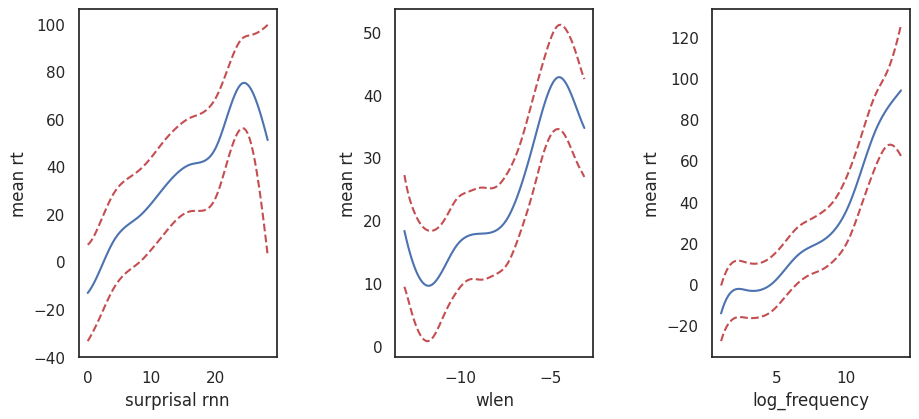

In [ ]:
## plotting
plt.figure();
fig, axs = plt.subplots(1,3, figsize=(10, 5));

titles = ['surprisal rnn','wlen', 'log_frequency']
for i, ax in enumerate(axs):
    XX = gam.generate_X_grid(term=i)
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')
    # ax.set_title(titles[i])
    ax.set_xlabel(titles[i])
    ax.set_ylabel('mean rt')

plt.tight_layout(pad=3)
plt.show()

# לעשות פלוט רק על סורפרייסל וזמני קריאה אחרי שהוא למד עם דברים נוספים
# גרף קלאסי קבוע שהקו האדום מתבסס על התוצאות של גאמ
# מודל גאמ צריך לקחת בחשבות את הspilover
# לראות את הקשר בין זה למילה הבאה

In all three features, surprisal, word length, and log of the frequency of the word, we can generally see a monotonicly increasing relation to the average reading time.

In [ ]:
# Generate predictions
y_pred = gam.predict(X)
y_pred=list(y_pred)

next_word_dic={}
current_word_dic={}
for (index,row) in combined_data.iterrows():
  if index==len(combined_data)-1:
    break
  sur=combined_data.iloc[index]["surp_rnn"]
  next_word_dic[sur]=y_pred[index+1]

for (index,row) in combined_data.iterrows():
  if index==len(combined_data):
    break
  sur=combined_data.iloc[index]["surp_rnn"]
  current_word_dic[sur] =y_pred[index]

In [ ]:
next_word_dic=dict(sorted(next_word_dic.items()))
keys_next_word =list( next_word_dic.keys())
values_next_word =list(next_word_dic.values())


current_word_dic=dict(sorted(current_word_dic.items()))
keys_current_word =list( current_word_dic.keys())
values_current_word =list(current_word_dic.values())


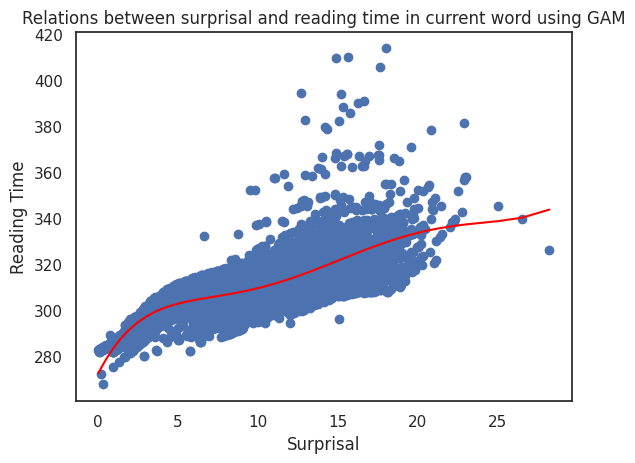

In [ ]:
# Plotting the graph
plt.scatter(keys_current_word, values_current_word)

#calculate equation for trendline
z = np.polyfit(keys_current_word, values_current_word, 6)
v = np.poly1d(z)

#add trendline to plot
# plt.axis([0, 0.05, 0, 30])
plt.plot(keys_current_word, v(keys_current_word),color="red",label="GAM current Word")


plt.xlabel('Surprisal')
plt.ylabel('Reading Time')
plt.title('Relations between surprisal and reading time in current word using GAM')
plt.show()

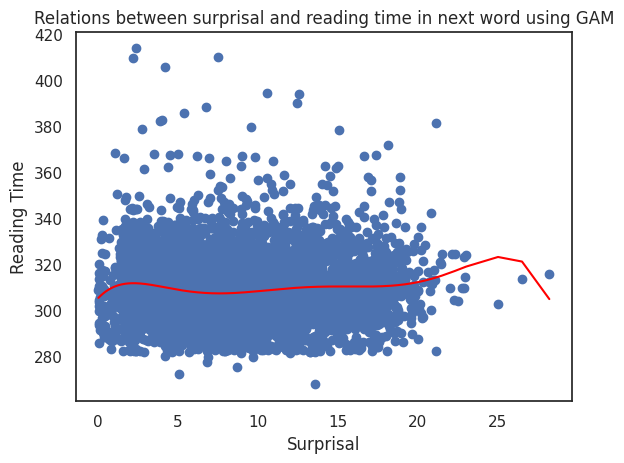

In [ ]:
plt.scatter(keys_next_word, values_next_word)
z = np.polyfit(keys_next_word, values_next_word, 6)
p = np.poly1d(z)
plt.plot(keys_next_word, p(keys_next_word),color="red",label="GAM Next Word")

plt.xlabel('Surprisal')
plt.ylabel('Reading Time')
plt.title('Relations between surprisal and reading time in next word using GAM')
plt.show()

The spillover effect is lower than the current word reading time effect.

## Train n-gram and RNN models on a larger dataset

We will train our RNN model on a larger dataset - wikitext-2, and examine the effect.

In [ ]:
dataset = load_dataset("wikitext", "wikitext-2-raw-v1")

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/36718 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

Dataset wikitext downloaded and prepared to /root/.cache/huggingface/datasets/wikitext/wikitext-2-raw-v1/1.0.0/a241db52902eaf2c6aa732210bead40c090019a499ceb13bcbfa3f8ab646a126. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
train_dataset = dataset["train"]
test_dataset = dataset["test"]

train_filename = f'{GDRIVE_DIR}/corpus_data/wiki_train_dataset.txt'
with open(train_filename, "w") as file:
    for example in train_dataset:
        file.write(example["text"] + "\n")

test_filename = f'{GDRIVE_DIR}/corpus_data/wiki_test_dataset.txt'
with open(test_filename, "w") as file:
    for example in test_dataset:
        file.write(example["text"] + "\n")

### Train Ngram model on Wikipedia

### Preprocess

In [ ]:
pip install https://github.com/kpu/kenlm/archive/master.zip

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 553.5/553.5 kB 16.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for kenlm: filename=kenlm-0.0.0-cp310-cp310-linux_x86_64.whl size=3255101 sha256=d23c488481201c71b010389856c3fd6d50ef9719b7dbae0a9d0927ab6836a8b4
  Stored in directory: /tmp/pip-ephem-wheel-cache-lo0185tv/wheels/a5/73/ee/670fbd0cee8f6f0b21d10987cb042291e662e26e1a07026462
Successfully built kenlm


In [ ]:
import kenlm

In [ ]:
!mkdir -p kenLM/models

In [ ]:
def create_text_for_kenlm(input_path, output_path):
    with open(input_path, 'r') as input_file, open(output_path, 'w') as output_file:
        for line in input_file:
            line = line.strip()
            if line:
                output_file.write(line + '\n')
    print("Done!")

In [ ]:
input_path = f'{GDRIVE_DIR}/corpus_data/wiki_train_dataset.txt'
output_path = f'{GDRIVE_DIR}/corpus_data/wiki_train_dataset_kenlm.txt'

create_text_for_kenlm(input_path, output_path)

Done!


In [ ]:
!apt-get install -y cmake libboost-all-dev zlib1g-dev build-essential
!git clone https://github.com/kpu/kenlm.git
!mkdir kenlm/build
!cd kenlm/build && cmake .. && make -j4

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libboost-all-dev is already the newest version (1.71.0.0ubuntu2).
build-essential is already the newest version (12.8ubuntu1.1).
cmake is already the newest version (3.16.3-1ubuntu1.20.04.1).
zlib1g-dev is already the newest version (1:1.2.11.dfsg-2ubuntu1.5).
zlib1g-dev set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 15 not upgraded.
Cloning into 'kenlm'...
remote: Enumerating objects: 14151, done.
remote: Counting objects: 100% (464/464), done.
remote: Compressing objects: 100% (325/325), done.
remote: Total 14151 (delta 155), reused 397 (delta 125), pack-reused 13687
Receiving objects: 100% (14151/14151), 5.91 MiB | 14.93 MiB/s, done.
Resolving deltas: 100% (8035/8035), done.
-- The C compiler identification is GNU 9.4.0
-- The CXX compiler identification is GNU 9.4.0
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Check for working C 

Train Ngram on wikipedia:

In [ ]:
!kenlm/build/bin/lmplz -o 5 --skip_symbols < "$GDRIVE_DIR/corpus_data/wiki_train_dataset_kenlm.txt" > /content/kenLM/models/five_gram_model.arpa

=== 1/5 Counting and sorting n-grams ===
Reading /content/gdrive/My Drive/096222_project_surprisals_and_rts/corpus_data/wiki_train_dataset_kenlm.txt
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
****************************************************************************************************
Unigram tokens 2051910 types 76619
=== 2/5 Calculating and sorting adjusted counts ===
Chain sizes: 1:919428 2:1062413760 3:1992025856 4:3187241216 5:4648060416
Statistics:
1 76619 D1=0.606829 D2=1.06583 D3+=1.47272
2 705256 D1=0.763577 D2=1.15175 D3+=1.42143
3 1463279 D1=0.879643 D2=1.27237 D3+=1.44934
4 1822384 D1=0.948087 D2=1.42476 D3+=1.53324
5 1924288 D1=0.961801 D2=1.54834 D3+=1.50361
Memory estimate for binary LM:
type     MB
probing 126 assuming -p 1.5
probing 149 assuming -r models -p 1.5
trie     60 without quantization
trie     33 assuming -q 8 -b 8 quantization 
trie     54 assuming -a 22 array pointer compression
trie     26 as

In [ ]:
model_path = '/content/kenLM/models/five_gram_model.arpa'
kenlm_5_model = kenlm.LanguageModel(model_path)

In [ ]:
import csv
text_file_path = '/content/rnn/data/brown.txt'
surprisal_file_path = "/content/brown_surp_wiki2.tsv"

with open(text_file_path, 'r') as text_file, open(surprisal_file_path, 'w', newline='') as output_file:
    writer = csv.writer(output_file, delimiter='\t')
    writer.writerow(['word', 'surp'])  # Write header row

    tokens = text_file.read().split()  # Split the text into tokens (words or sentences)

    for token in tokens:
        log_prob = kenlm_5_model.score(token)
        surprisal = -log_prob
        writer.writerow([token, surprisal])

In [ ]:
df_surp_wiki_ngram = pd.read_csv("/content/brown_surp_wiki2.tsv", sep='\t')

In [ ]:
df_surp_wiki_ngram.to_csv(f'{GDRIVE_DIR}/wiki_surp_ngram.csv', index=False)

### Analysis of Ngram

In [ ]:
# reload from here
surp_wiki_ngram = pd.read_csv(f'{GDRIVE_DIR}/wiki_surp_ngram.csv')
surp_wiki_ngram

,word,surp
0,In,4.802285
1,Ireland's,9.552349
2,County,7.356017
3,"Limerick,",9.552349
4,near,7.299095
...,...,...
7229,as,6.435362
7230,a,6.655516
7231,leader,8.071894
7232,and,5.840184


In [ ]:
# replace word column to fit the unknowns of the rt model, reload the original (7234) rnn_surprisals!
surp_wiki_ngram["word"] = rnn_surprisals["word"]

In [ ]:
surp_wiki_ngram["surp"].corr(rnn_surprisals["surp"])

0.17519362570539537

In [ ]:
surp_wiki_ngram.drop(surp_wiki_ngram.index[(surp_wiki_ngram["word"] == "</s>")], axis=0, inplace=True)
surp_wiki_ngram.drop(surp_wiki_ngram.index[(surp_wiki_ngram["word"] == "<unk>")], axis=0, inplace=True)
surp_wiki_ngram.drop(surp_wiki_ngram.index[(surp_wiki_ngram["word"] == "--")], axis=0, inplace=True)
surp_wiki_ngram = surp_wiki_ngram.reset_index(drop = True)
surp_wiki_ngram

,word,surp
0,In,4.802285
1,County,7.356017
2,near,7.299095
3,the,6.422550
4,River,7.059133
...,...,...
5496,failed,8.046458
5497,as,6.435362
5498,a,6.655516
5499,leader,8.071894


In [ ]:
#sainity check, now the rnn surprisals is also after cleaning (run the cell of clean rnn_surprisals)
surp_wiki_ngram["surp"].corr(rnn_surprisals["surp"])

0.7174712239114699

In [ ]:
surp_wiki_ngram["surp"].corr(ngram_surprisals['mean_rt'])

0.09953017311598195

In [ ]:
surp_wiki_ngram['mean_rt'] = ngram_surprisals['mean_rt']

In [ ]:
surp_wiki_ngram["surp"].corr(ngram_surprisals["surprisal"])

0.7440037300327599

In [ ]:
surp_wiki_ngram["surp"].corr(ngram_surprisals["mean_rt"])

0.09953017311598195

In [ ]:
corr_wiki_ngram_rt = surp_wiki_ngram['mean_rt'].corr(surp_wiki_ngram['surp'])
corr_wiki_ngram_ptb_ngram = surp_wiki_ngram['surp'].corr(ngram_surprisals['surprisal'])
print(f'The correlation between the surprisal wiki Ngram to reading time {corr_wiki_ngram_rt}')
print(f'The correlation between the surprisal wiki Ngram to surprisal Ngram ptb {corr_wiki_ngram_ptb_ngram}')

The correlation between the surprisal wiki Ngram to reading time 0.09953017311598195
The correlation between the surprisal wiki Ngram to surprisal Ngram ptb 0.7440037300327599


We can see that the surprisal calculated using Ngram on wiki prediced reading time worse than the RNN model trained on Wikipedia.
The Ngram models trained on ptb and Wikipedia have high corrolation.

In [ ]:
surp_wiki_ngram['ptb_surp'] = rnn_surprisals['surp']
surp_wiki_ngram['ngram_surp'] = ngram_surprisals['surprisal']
surp_wiki_ngram['mean_rt'] = ngram_surprisals['mean_rt']
surp_wiki_ngram = surp_wiki_ngram.rename(columns={'surp':'wiki_surp'})
surp_wiki_ngram

,word,wiki_surp,mean_rt,ptb_surp,ngram_surp
0,In,4.802285,380.275294,5.506053,4.57937
1,County,7.356017,296.042941,12.514248,12.65410
2,near,7.299095,403.553529,13.308077,12.22380
3,the,6.422550,306.075882,1.662673,1.98095
4,River,7.059133,289.048235,17.830992,15.70900
...,...,...,...,...,...
5496,failed,8.046458,292.772500,9.048445,8.25341
5497,as,6.435362,284.470833,6.248776,9.42416
5498,a,6.655516,282.622083,2.861911,3.23962
5499,leader,8.071894,279.445417,11.365563,12.81650


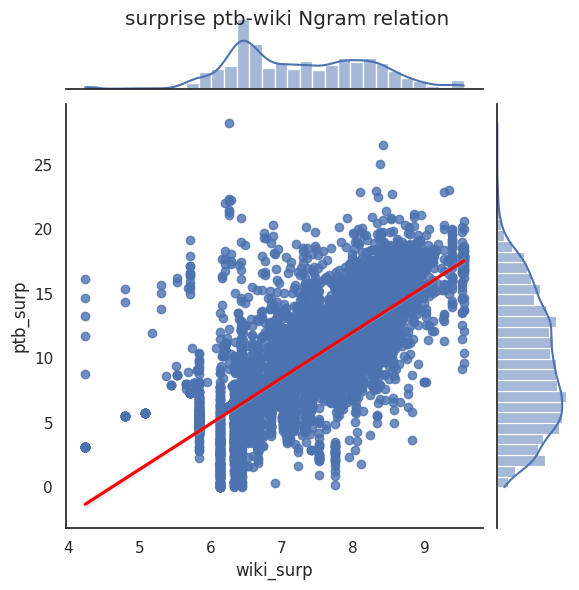

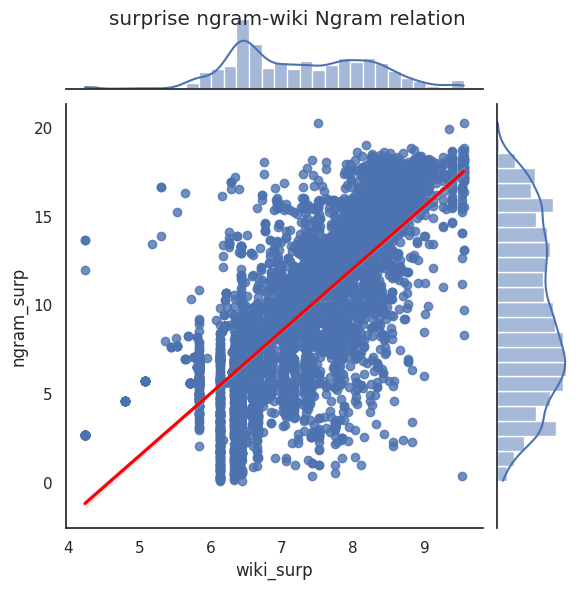

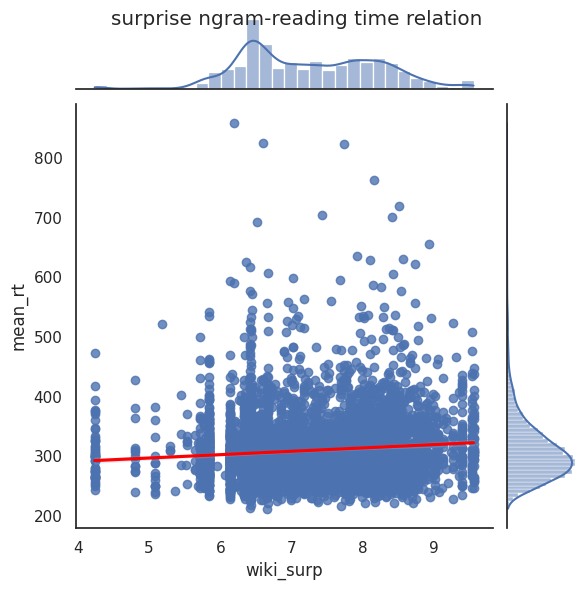

In [ ]:
plot_relation(surp_wiki_ngram,'wiki_surp','ptb_surp','surprise ptb-wiki Ngram relation')
plot_relation(surp_wiki_ngram,'wiki_surp','ngram_surp','surprise ngram-wiki Ngram relation')
plot_relation(surp_wiki_ngram,'wiki_surp','mean_rt','surprise ngram-reading time relation')

### Spillover effect

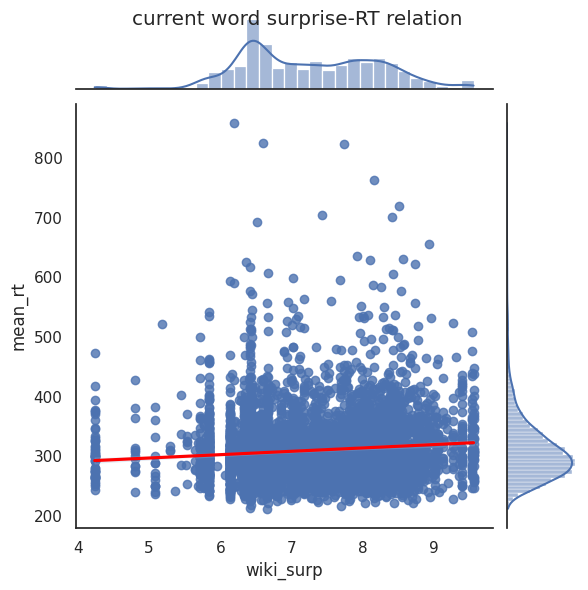

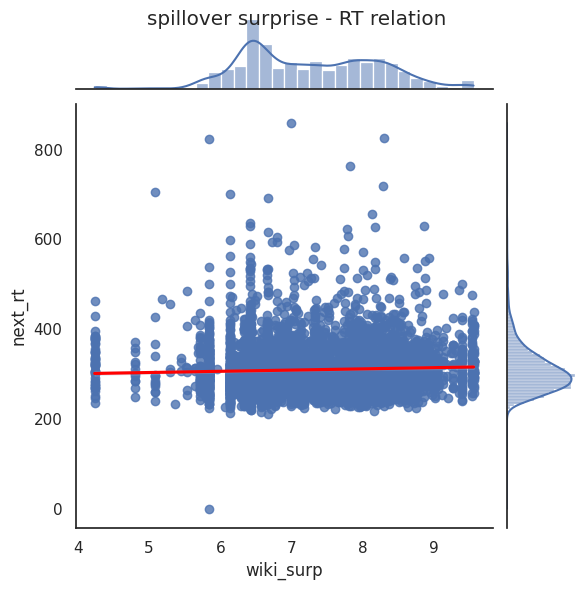

In [ ]:
surp_wiki_ngram = add_next_rt(surp_wiki_ngram)
plot_relation(surp_wiki_ngram,'wiki_surp','mean_rt','current word surprise-RT relation')
plot_relation(surp_wiki_ngram,'wiki_surp','next_rt','spillover surprise - RT relation')

### Train RNN model on Wikipedia

In [ ]:
!cd rnn && python main.py --cuda --model_file "$GDRIVE_DIR/wiki_model.pt" \
    --epochs 40 \
    --vocab_file "$GDRIVE_DIR/wiki_vocab.txt" \
    --tied --data_dir "$GDRIVE_DIR/corpus_data/" --trainfname wiki_train_dataset.txt --validfname wiki_test_dataset.txt

In [ ]:
checkpoint_to_use = f"{GDRIVE_DIR}/wiki_model.pt"
!cd rnn && python main.py --cuda --model_file "$checkpoint_to_use" \
    --vocab_file "$GDRIVE_DIR/wiki_vocab.txt" --data_dir './data' \
    --testfname 'brown.txt' --test --words --nopp > "$GDRIVE_DIR/wiki_rnn_surprisals.tsv"

Libraries loaded
Using beamsize: 76618


In [ ]:
wiki_rnn_surprisals = pd.read_csv(f'{GDRIVE_DIR}/wiki_rnn_surprisals.tsv',sep=' ')
wiki_rnn_surprisals

,word,sentid,sentpos,wlen,surp,entropy,entred
0,In,0,0,2,5.871775,12.300210,0.000000
1,<unk>,0,1,5,22.741152,8.324606,3.975604
2,County,0,2,6,11.768429,4.992474,3.332132
3,<unk>,0,3,5,22.797188,8.022927,0.000000
4,near,0,4,4,10.621149,4.809686,3.213241
...,...,...,...,...,...,...,...
7229,as,363,15,2,5.441105,5.058009,3.604892
7230,a,363,16,1,2.420145,7.740427,0.000000
7231,leader,363,17,6,12.275949,12.003860,0.000000
7232,and,363,18,3,4.415491,5.904001,6.099860


In [ ]:
wiki_rnn_surprisals['surp'].corr(surp_wiki_ngram['surp'])

0.8829556632673431

In [ ]:
wiki_rnn_surprisals['surp'].corr(rnn_surprisals['surp'])

0.2626111347697252

When examining our data that the model outputed after training on the wikitext we found that there were less unknown words. This makes sense since the unkown words are based on the words that model was not able to learn the the Wikitext dataset is much larger than the PTB dataset which is smaller. And so in order to harmonized the new data and to be able to match it to the reading time we will match between the results of the previous model and its unknown words to the results from the new model

In [ ]:
rnn_surprisals = pd.read_csv(f'{GDRIVE_DIR}/rnn_surprisals.tsv',sep=' ')
wiki_rnn_surprisals['word'] = rnn_surprisals['word']

wiki_rnn_surprisals.drop(wiki_rnn_surprisals.index[(wiki_rnn_surprisals["word"] == "</s>")], axis=0, inplace=True)
wiki_rnn_surprisals.drop(wiki_rnn_surprisals.index[(wiki_rnn_surprisals["word"] == "<unk>")], axis=0, inplace=True)
wiki_rnn_surprisals.drop(wiki_rnn_surprisals.index[(wiki_rnn_surprisals["word"] == "--")], axis=0, inplace=True)
wiki_rnn_surprisals = wiki_rnn_surprisals.reset_index(drop = True)
wiki_rnn_surprisals


,word,sentid,sentpos,wlen,surp,entropy,entred
0,In,0,0,2,5.871775,12.300210,0.000000
1,County,0,2,6,11.768429,4.992474,3.332132
2,near,0,4,4,10.621149,4.809686,3.213241
3,the,0,5,3,1.727962,9.091868,0.000000
4,River,0,6,5,11.868165,11.354079,0.000000
...,...,...,...,...,...,...,...
5496,failed,363,14,6,9.583843,8.662901,0.000000
5497,as,363,15,2,5.441105,5.058009,3.604892
5498,a,363,16,1,2.420145,7.740427,0.000000
5499,leader,363,17,6,12.275949,12.003860,0.000000


In [ ]:
sprt_grouped, surp_wiki_clean = clean_data(sprt, wiki_rnn_surprisals)
harmonized_wiki = harmonize(sprt_grouped, surp_wiki_clean)
harmonized_wiki.to_csv(f'{GDRIVE_DIR}/harmonized_wiki.csv')
harmonized_wiki

,word,sentid,sentpos,wlen,surprisal,mean_rt
0,In,0,0,2,5.871775,380.275294
1,County,0,2,6,11.768429,296.042941
2,near,0,4,4,10.621149,403.553529
3,the,0,5,3,1.727962,306.075882
4,River,0,6,5,11.868165,289.048235
...,...,...,...,...,...,...
5496,failed,363,14,6,9.583843,292.772500
5497,as,363,15,2,5.441105,284.470833
5498,a,363,16,1,2.420145,282.622083
5499,leader,363,17,6,12.275949,279.445417


In [ ]:
harmonized_wiki_df = pd.read_csv(f'{GDRIVE_DIR}/harmonized_wiki.csv')
harmonized_wiki_df

,Unnamed: 0,word,sentid,sentpos,wlen,surprisal,mean_rt
0,0,In,0,0,2,5.871775,380.275294
1,1,County,0,2,6,11.768429,296.042941
2,2,near,0,4,4,10.621149,403.553529
3,3,the,0,5,3,1.727962,306.075882
4,4,River,0,6,5,11.868165,289.048235
...,...,...,...,...,...,...,...
5496,5496,failed,363,14,6,9.583843,292.772500
5497,5497,as,363,15,2,5.441105,284.470833
5498,5498,a,363,16,1,2.420145,282.622083
5499,5499,leader,363,17,6,12.275949,279.445417


In [ ]:
# corr_wiki_ngram = ngram_surprisals['surprisal'].corr(harmonized_wiki_df['wiki_surp'])
corr_wiki_rt = harmonized_wiki_df['mean_rt'].corr(harmonized_wiki_df['surprisal'])
corr_wiki_ptb = rnn_surprisals['surp'].corr(harmonized_wiki_df['surprisal'])
corr_ngram_rnn_wiki = harmonized_wiki_df['surprisal'].corr(surp_wiki_ngram["surp"])
print(f'The correlation between the surprisal wiki RNN to reading time {corr_wiki_rt}')
print(f'The correlation between the surprisal wiki RNN to surprisal RNN ptb {corr_wiki_ptb}')
print(f'The correlation between the surprisal wiki RNN wiki Ngram {corr_ngram_rnn_wiki}')
# print(f'The correlation between the surprisal wiki to surprisal ngram {corr_wiki_ngram}')

The correlation between the surprisal wiki RNN to reading time 0.17615391540552042
The correlation between the surprisal wiki RNN to surprisal RNN ptb 0.8891728926046172
The correlation between the surprisal wiki RNN wiki Ngram 0.7499943258773009


The model based on wikitext is not better than the ptb model. This is a surprise.

In [ ]:
harmonized_wiki_df['ptb_surp'] = rnn_surprisals['surp']
harmonized_wiki_df['ngram_surp'] = ngram_surprisals['surprisal']
harmonized_wiki_df['mean_rt'] = ngram_surprisals['mean_rt']
harmonized_wiki_df = harmonized_wiki_df.rename(columns={'surprisal':'wiki_surp'})
harmonized_wiki_df

### Relation betwenn different models trained on different dataset:

In [ ]:
harmonized_wiki_df['wiki_surp'].corr(harmonized_wiki_df['ngram_surp'])

0.8214000484678458

In [ ]:
harmonized_wiki_df['wiki_surp'].corr(harmonized_wiki_df['ptb_surp'])

0.8891728926046174

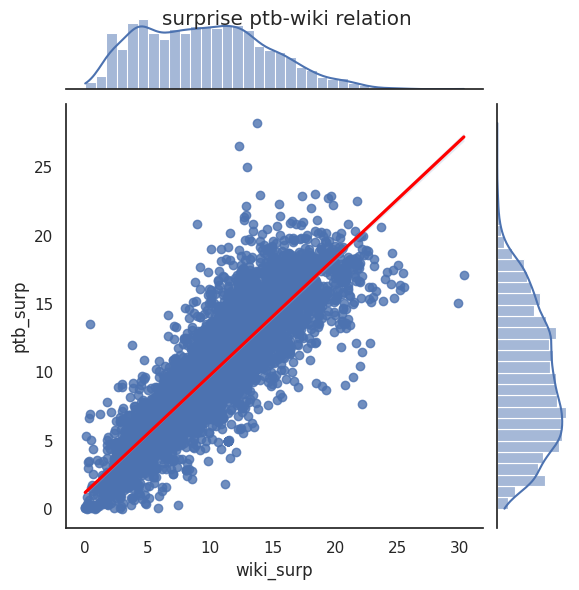

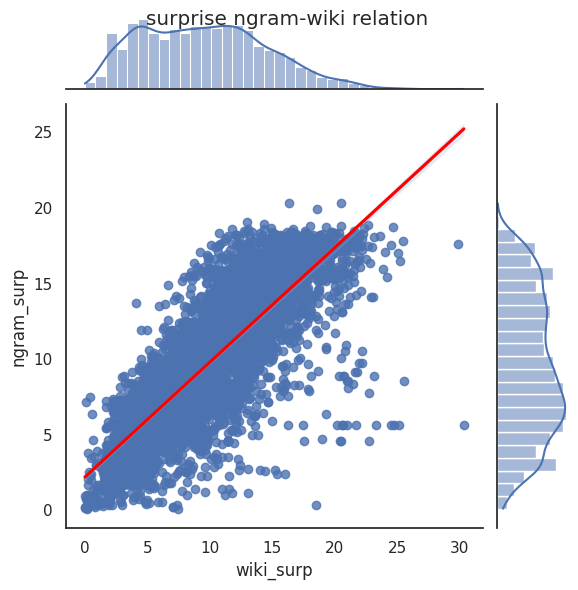

In [ ]:
plot_relation(harmonized_wiki_df,'wiki_surp','ptb_surp','surprise ptb-wiki relation')
plot_relation(harmonized_wiki_df,'wiki_surp','ngram_surp','surprise ngram-wiki relation')

### Spillover Effect:

In [ ]:
harmonized_wiki_df = add_next_rt(harmonized_wiki_df)

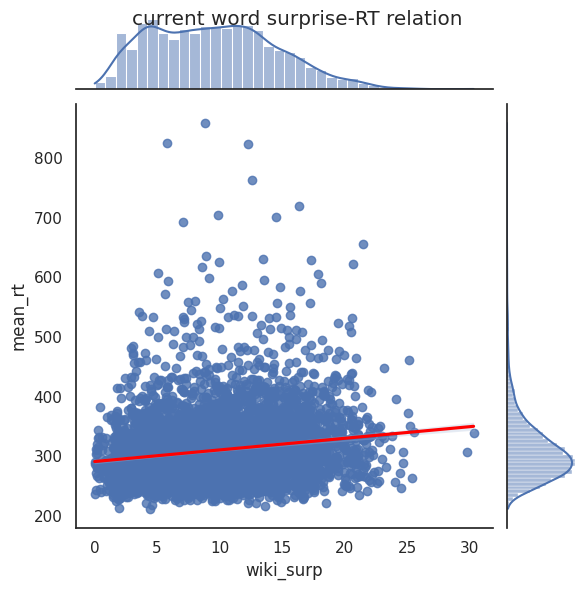

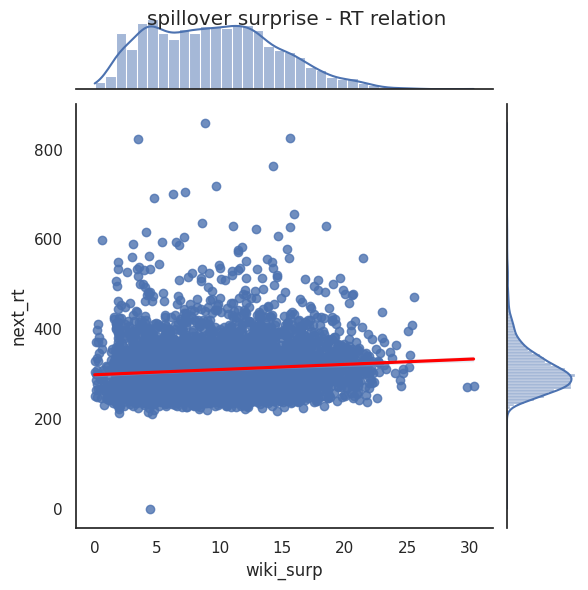

In [ ]:
plot_relation(harmonized_wiki_df,'wiki_surp','mean_rt','current word surprise-RT relation')
plot_relation(harmonized_wiki_df,'wiki_surp','next_rt','spillover surprise - RT relation')

# Part 3:

In this part we will train our RNN model on different novels from different time periods and examine the effect it has on surpris

Preprocessing - for each book we will split the text into sentences if needed, lowercase all the words and extract the vocabulary.

## Crime and Punishment

In [ ]:
with open(f'{GDRIVE_DIR}/corpus_data/crime_and_punishment.txt') as f:
  lines = f.readlines()

crime_and_punishment = split_sentences(lines)

words = [l.split(' ') for l in crime_and_punishment]
words.append("<eos>\n")
vocab = set(list(chain.from_iterable(words)))
vocab.add('<eos>\n')
vocab.add('<unk>\n')
with open(f'{GDRIVE_DIR}/crime_and_punishment_vocab.txt', 'w') as f:
  for line in vocab:
      if line.endswith(','):
        f.write(f"{line[:-1]}\n")
      else:
        f.write(f"{line}\n")

In [ ]:
random.shuffle(crime_and_punishment)
train_crime_and_punishment = crime_and_punishment[:int(len(crime_and_punishment)*0.8)]
test_crime_and_punishment = crime_and_punishment[len(crime_and_punishment)-int(len(crime_and_punishment)*0.8):]

with open(f'{GDRIVE_DIR}/corpus_data/crime_and_punishment_train.txt', 'w') as f:
  for line in train_crime_and_punishment:
      f.write(f"{line}\n")
with open(f'{GDRIVE_DIR}/corpus_data/crime_and_punishment_test.txt', 'w') as f:
  for line in test_crime_and_punishment:
      f.write(f"{line}\n")

In [ ]:
!cd rnn && python main.py --cuda --model_file "$GDRIVE_DIR/crime_and_punishment_model.pt" \
    --epochs 40 \
    --vocab_file "$GDRIVE_DIR/crime_and_punishment_vocab.txt" \
    --tied --data_dir "$GDRIVE_DIR/corpus_data" --trainfname crime_and_punishment_train.txt --validfname crime_and_punishment_test.txt

In [ ]:
checkpoint_to_use = f"{GDRIVE_DIR}/crime_and_punishment_model.pt"
!cd rnn && python main.py --cuda --model_file "$checkpoint_to_use" \
    --vocab_file "$GDRIVE_DIR/crime_and_punishment_vocab.txt" --data_dir './data' \
    --testfname 'brown.txt' --test --words --nopp > "$GDRIVE_DIR/crime_and_punishment_rnn_surprisals.tsv"

Libraries loaded
Using beamsize: 13027


In [ ]:
crime_and_punishment_rnn_surprisals = pd.read_csv(f'{GDRIVE_DIR}/crime_and_punishment_rnn_surprisals.tsv',sep=' ', quoting=csv.QUOTE_NONE)
crime_and_punishment_rnn_surprisals.shape

(7234, 7)

In [ ]:
harmonized_wiki_df = pd.read_csv(f'{GDRIVE_DIR}/harmonized_wiki.csv')
harmonized_wiki_df.rename(columns={'surprisal': 'wiki_surp'}, inplace=True)
harmonized_cp, limited_cp = create_harmonize_limited(sprt, crime_and_punishment_rnn_surprisals, harmonized_wiki_df,'cp')

In [ ]:
corr_rnn_cp = harmonized_cp['mean_rt'].corr(harmonized_cp['cp_surp'])
print(f'The correlation between surprisal and readint time for a RNN model trained on Crime and Punishment book is {corr_rnn_cp}')

The correlation between surprisal and readint time for a RNN model trained on Crime and Punishment book is 0.16898898213578067


In [ ]:
cp_with_next = add_next_rt(limited_cp)


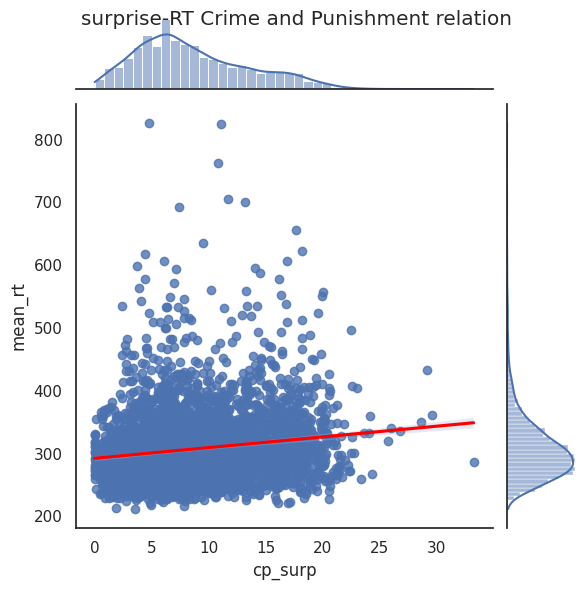

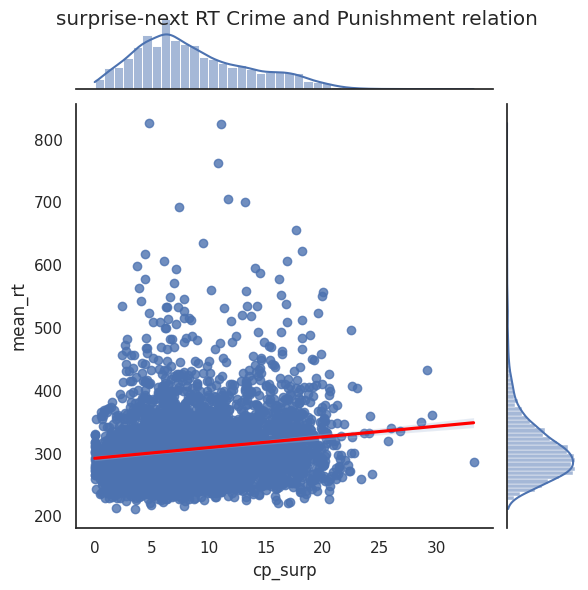

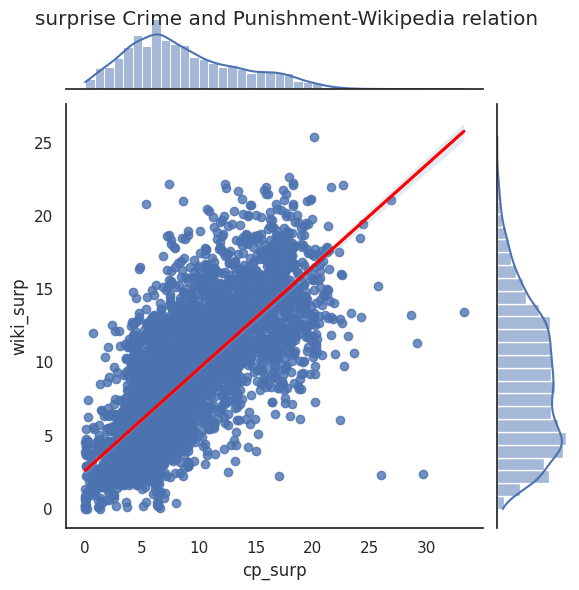

In [ ]:
plot_all(limited_cp, cp_with_next, 'cp_surp', 'mean_rt', 'Crime and Punishment')

In [ ]:
checkpoint_to_use = f"{GDRIVE_DIR}/crime_and_punishment_model.pt"
!cd rnn && python main.py --cuda --model_file "$checkpoint_to_use" \
    --vocab_file "$GDRIVE_DIR/crime_and_punishment_vocab.txt" --data_dir './data' \
    --testfname 'wikitext-2/test.txt' --test --words --nopp > "$GDRIVE_DIR/cp_on_wiki_surprisal.tsv"

!cd rnn && python main.py --cuda --model_file "$checkpoint_to_use" \
    --vocab_file "$GDRIVE_DIR/crime_and_punishment_vocab.txt" --data_dir './data' \
    --testfname 'hp_test.txt' --test --words --nopp > "$GDRIVE_DIR/cp_on_1984_surprisal.tsv"

!cd rnn && python main.py --cuda --model_file "$checkpoint_to_use" \
    --vocab_file "$GDRIVE_DIR/crime_and_punishment_vocab.txt" --data_dir './data' \
    --testfname 'crime_and_punishment_test.txt' --test --words --nopp > "$GDRIVE_DIR/cp_on_cp_surprisal.tsv"

!cd rnn && python main.py --cuda --model_file "$checkpoint_to_use" \
    --vocab_file "$GDRIVE_DIR/crime_and_punishment_vocab.txt" --data_dir './data' \
    --testfname 'hp_test.txt' --test --words --nopp > "$GDRIVE_DIR/cp_on_hp_surprisal.tsv"


Libraries loaded
Using beamsize: 13027
Libraries loaded
Using beamsize: 13027
Libraries loaded
Using beamsize: 13027
Libraries loaded
Using beamsize: 13027


## 1984

In [ ]:
with open(f'{GDRIVE_DIR}/corpus_data/1984.txt') as f:
  lines = f.readlines()

b_1984 = [l[:-1] for l in lines if l != '\n']


words = [l.split(' ') for l in b_1984]
vocab = set(list(chain.from_iterable(words)))
vocab.add('<eos>\n')
vocab.add('<unk>\n')
with open(f'{GDRIVE_DIR}/vocab_1984.txt', 'w') as f:
  f.write("<eos>\n")
  for line in vocab:
      f.write(f"{line}\n")

In [ ]:
random.shuffle(b_1984)
train_b_1984 = b_1984[:int(len(b_1984)*0.8)]
test_b_1984 = b_1984[len(b_1984)-int(len(b_1984)*0.8):]

with open(f'{GDRIVE_DIR}/corpus_data/b_1984_train.txt', 'w') as f:
  for line in train_b_1984:
      f.write(f"{line}\n")
with open(f'{GDRIVE_DIR}/corpus_data/b_1984_test.txt', 'w') as f:
  for line in test_b_1984:
      f.write(f"{line}\n")

In [ ]:
!cd rnn && python main.py --cuda --model_file "$GDRIVE_DIR/1984_model.pt" \
    --epochs 40 \
    --vocab_file "$GDRIVE_DIR/1984_vocab.txt" \
    --tied --data_dir "$GDRIVE_DIR/corpus_data" --trainfname b_1984_train.txt --validfname b_1984_test.txt

Libraries loaded
-----------------------------------------------------------------------------------------
| end of epoch   1 | time:  0.32s | lr: 20.00000000 | valid ppl  3123.75
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch   2 | time:  0.07s | lr: 20.00000000 | valid ppl 28011.33
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch   3 | time:  0.07s | lr: 2.00000000 | valid ppl  1084.64
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch   4 | time:  0.07s | lr: 2.00000000 | valid ppl   657.33
---------------------------------------------------------------

In [ ]:
checkpoint_to_use = f"{GDRIVE_DIR}/1984_model.pt"
!cd rnn && python main.py --cuda --model_file "$checkpoint_to_use" \
    --vocab_file "$GDRIVE_DIR/1984_vocab.txt" --data_dir './data' \
    --testfname 'brown.txt' --test --words --nopp > "$GDRIVE_DIR/b_1984_rnn_surprisals.tsv"

Libraries loaded
Using beamsize: 1730


In [ ]:
b_1984_rnn_surprisals = pd.read_csv(f'{GDRIVE_DIR}/b_1984_rnn_surprisals.tsv',sep=' ', quoting=csv.QUOTE_NONE)
b_1984_rnn_surprisals.shape

(7234, 7)

In [ ]:
harmonized_1984, limited_1984 = create_harmonize_limited(sprt, b_1984_rnn_surprisals, harmonized_wiki_df,'1984')

In [ ]:
limited_1984

,word,sentid,sentpos,wlen,1984_surp,mean_rt,wiki_surp,ptb_surp,ngram_surp,next_rt
0,In,0,0,2,9.534801,380.275294,5.871717,5.506053,4.57937,296.042941
1,near,0,4,4,11.794127,403.553529,10.620914,13.308077,12.22380,306.075882
2,the,0,5,3,4.225196,306.075882,1.727838,1.662673,1.98095,289.048235
3,there,0,8,5,8.308720,346.305294,11.691103,13.024343,11.74150,306.631176
4,a,0,10,1,5.227254,281.776471,3.772337,2.099516,2.35382,258.036471
...,...,...,...,...,...,...,...,...,...,...
3914,he,363,12,2,6.551397,288.550000,4.478800,5.369756,5.49292,258.918333
3915,had,363,13,3,6.341028,258.918333,3.813534,4.761326,3.35892,292.772500
3916,as,363,15,2,7.118371,284.470833,5.441115,6.248776,9.42416,282.622083
3917,a,363,16,1,5.190668,282.622083,2.420166,2.861911,3.23962,279.445417


In [ ]:
corr_rnn_1984 = harmonized_1984['mean_rt'].corr(limited_1984['1984_surp'])
print(f'The correlation between surprisal and reading time for a RNN model trained on 1984 book is {corr_rnn_1984}')

The correlation between surprisal and reading time for a RNN model trained on 1984 book is 0.0037608169972928713


In [ ]:
b_1984_with_next = add_next_rt(limited_1984)


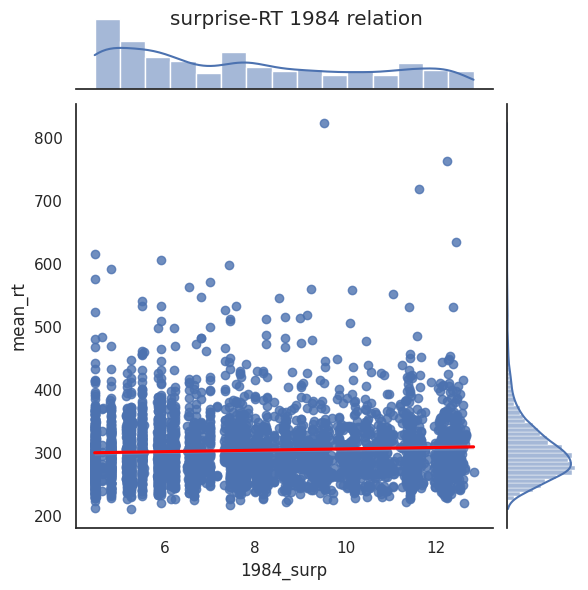

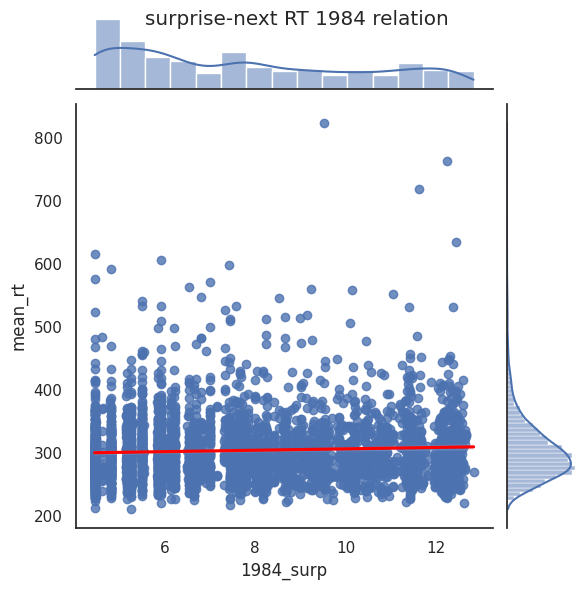

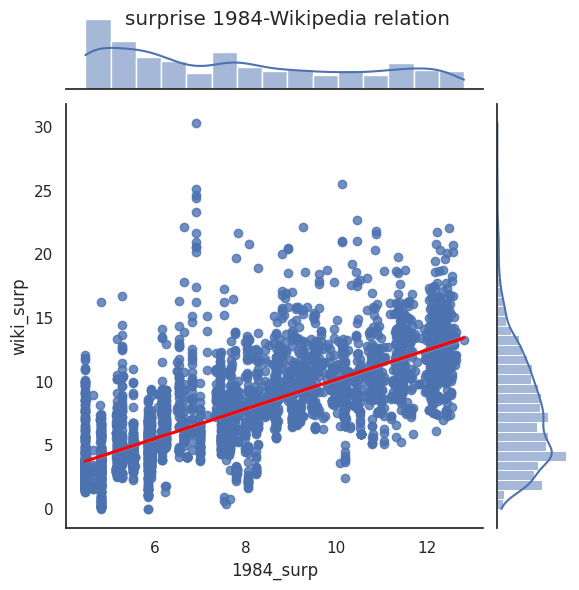

In [ ]:
plot_all(limited_1984, b_1984_with_next, '1984_surp', 'mean_rt', '1984')

In [ ]:
checkpoint_to_use = f"{GDRIVE_DIR}/1984_model.pt"
!cd rnn && python main.py --cuda --model_file "$checkpoint_to_use" \
    --vocab_file "$GDRIVE_DIR/1984_vocab.txt" --data_dir './data' \
    --testfname 'wikitext-2/test.txt' --test --words --nopp > "$GDRIVE_DIR/1984_on_wiki_surprisal.tsv"

!cd rnn && python main.py --cuda --model_file "$checkpoint_to_use" \
    --vocab_file "$GDRIVE_DIR/1984_vocab.txt" --data_dir './data' \
    --testfname 'hp_test.txt' --test --words --nopp > "$GDRIVE_DIR/1984_on_1984_surprisal.tsv"

!cd rnn && python main.py --cuda --model_file "$checkpoint_to_use" \
    --vocab_file "$GDRIVE_DIR/1984_vocab.txt" --data_dir './data' \
    --testfname 'crime_and_punishment_test.txt' --test --words --nopp > "$GDRIVE_DIR/1984_on_cp_surprisal.tsv"

!cd rnn && python main.py --cuda --model_file "$checkpoint_to_use" \
    --vocab_file "$GDRIVE_DIR/1984_vocab.txt" --data_dir './data' \
    --testfname 'hp_test.txt' --test --words --nopp > "$GDRIVE_DIR/1984_on_hp_surprisal.tsv"


Libraries loaded
Using beamsize: 1730
Libraries loaded
Using beamsize: 1730
Libraries loaded
Using beamsize: 1730
Libraries loaded
Using beamsize: 1730


## Harry Potter

In [ ]:
with open(f'{GDRIVE_DIR}/corpus_data/Harry_Potter.txt') as f:
  lines = f.readlines()

lines[:10]

hp = [l[:-1] for l in lines if l != '\n']
hp[:10]

from itertools import chain
words = [l.split(' ') for l in hp]
vocab = set(list(chain.from_iterable(words)))
vocab.add('<eos>\n')
vocab.add('<unk>\n')

with open(f'{GDRIVE_DIR}/vocab_hp.txt', 'w') as f:
  for line in vocab:
      f.write(f"{line}\n")

In [ ]:
random.shuffle(hp)
train_hp = hp[:int(len(hp)*0.8)]
test_hp = hp[len(hp)-int(len(hp)*0.8):]
with open(f'{GDRIVE_DIR}/corpus_data/hp_train.txt', 'w') as f:
  for line in train_hp:
      f.write(f"{line}\n")
with open(f'{GDRIVE_DIR}/corpus_data/hp_test.txt', 'w') as f:
  for line in test_hp:
      f.write(f"{line}\n")

In [ ]:
!cd rnn && python main.py --cuda --model_file "$GDRIVE_DIR/hp_model.pt" \
    --epochs 40 \
    --vocab_file "$GDRIVE_DIR/hp_vocab.txt" \
    --tied --data_dir "$GDRIVE_DIR/corpus_data" --trainfname hp_train.txt --validfname hp_test.txt


Libraries loaded
| epoch   1 |   200/  327 batches | lr 20.00 | ms/batch 13.37 | loss  6.88 | ppl   975.99
-----------------------------------------------------------------------------------------
| end of epoch   1 | time:  5.40s | lr: 20.00000000 | valid ppl   351.61
-----------------------------------------------------------------------------------------
| epoch   2 |   200/  327 batches | lr 20.00 | ms/batch 12.03 | loss  5.91 | ppl   369.74
-----------------------------------------------------------------------------------------
| end of epoch   2 | time:  5.23s | lr: 20.00000000 | valid ppl   275.03
-----------------------------------------------------------------------------------------
| epoch   3 |   200/  327 batches | lr 20.00 | ms/batch 12.09 | loss  5.73 | ppl   308.23
-----------------------------------------------------------------------------------------
| end of epoch   3 | time:  5.21s | lr: 20.00000000 | valid ppl   240.97
--------------------------------------------

In [ ]:
checkpoint_to_use = f"{GDRIVE_DIR}/hp_model.pt"
!cd rnn && python main.py --cuda --model_file "$checkpoint_to_use" \
    --vocab_file "$GDRIVE_DIR/hp_vocab.txt" --data_dir './data' \
    --testfname 'brown.txt' --test --words --nopp > "$GDRIVE_DIR/hp_rnn_surprisals.tsv"

Libraries loaded
Using beamsize: 23034


In [ ]:
hp_rnn_surprisals = pd.read_csv(f'{GDRIVE_DIR}/hp_rnn_surprisals.tsv',sep=' ', quoting=csv.QUOTE_NONE)
hp_rnn_surprisals.shape

(7234, 7)

In [ ]:
harmonized_hp, limited_hp = create_harmonize_limited(sprt, hp_rnn_surprisals, harmonized_wiki_df,'hp')

In [ ]:
corr_rnn_hp = harmonized_hp['mean_rt'].corr(harmonized_hp['hp_surp'])
print(f'The correlation between surprisal and reading time for a RNN model trained on Harry potter book is {corr_rnn_hp}')

The correlation between surprisal and reading time for a RNN model trained on Harry potter book is 0.2018181353215432


In [ ]:
hp_with_next = add_next_rt(limited_hp)


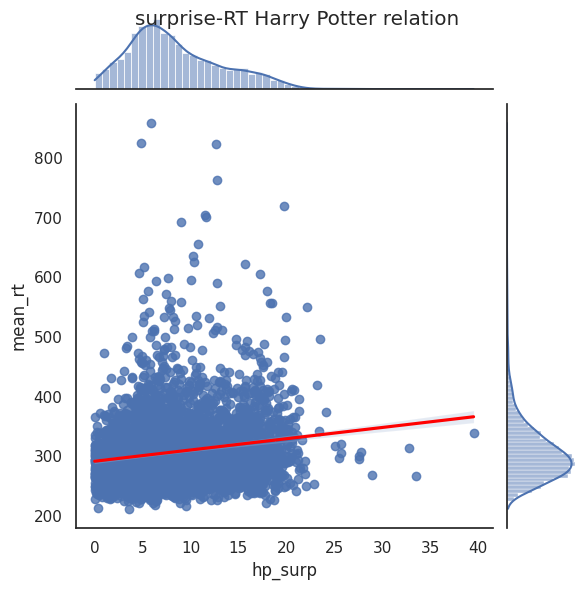

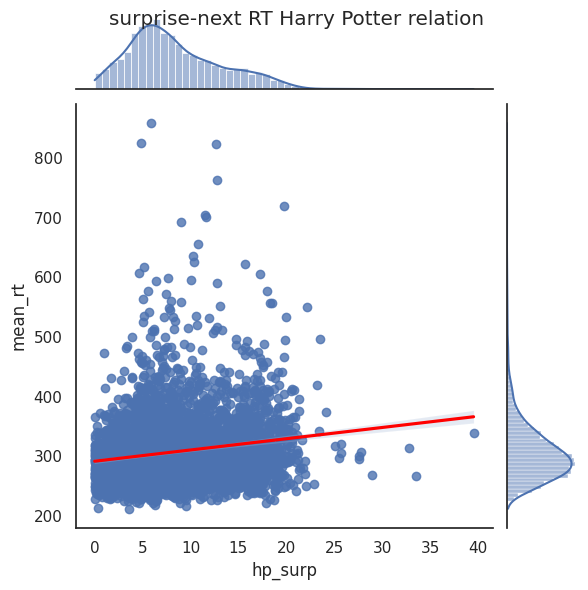

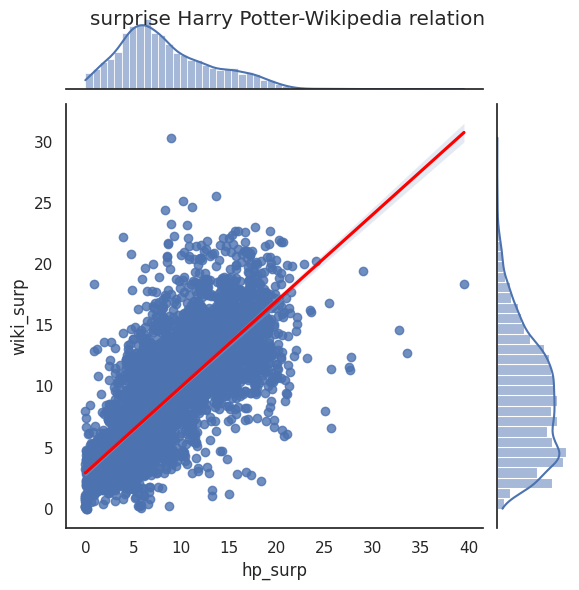

In [ ]:
plot_all(limited_hp, hp_with_next, 'hp_surp', 'mean_rt', 'Harry Potter')

We can observe that in general the trend is mostly the same between the models. (both modern, but wikipedia is more proffesional languege).
In Harry potter's based model we have more (rikuz) surprisal in range of 5-10, while wiki is more spreads.

### Examining model trained on Harry Potter book predicting surprisal on other books:

In [ ]:
checkpoint_to_use = f"{GDRIVE_DIR}/hp_model.pt"
!cd rnn && python main.py --cuda --model_file "$checkpoint_to_use" \
    --vocab_file "$GDRIVE_DIR/hp_vocab.txt" --data_dir './data' \
    --testfname 'wikitext-2/test.txt' --test --words --nopp > "$GDRIVE_DIR/hp_on_wiki_surprisal.tsv"

!cd rnn && python main.py --cuda --model_file "$checkpoint_to_use" \
    --vocab_file "$GDRIVE_DIR/hp_vocab.txt" --data_dir './data' \
    --testfname 'hp_test.txt' --test --words --nopp > "$GDRIVE_DIR/hp_on_1984_surprisal.tsv"

!cd rnn && python main.py --cuda --model_file "$checkpoint_to_use" \
    --vocab_file "$GDRIVE_DIR/hp_vocab.txt" --data_dir './data' \
    --testfname 'crime_and_punishment_test.txt' --test --words --nopp > "$GDRIVE_DIR/hp_on_cp_surprisal.tsv"

!cd rnn && python main.py --cuda --model_file "$checkpoint_to_use" \
    --vocab_file "$GDRIVE_DIR/hp_vocab.txt" --data_dir './data' \
    --testfname 'hp_test.txt' --test --words --nopp > "$GDRIVE_DIR/hp_on_hp_surprisal.tsv"


Libraries loaded
Using beamsize: 23034
Libraries loaded
Using beamsize: 23034
Libraries loaded
Using beamsize: 23034
Libraries loaded
Using beamsize: 23034


## Comparing different models:

In [ ]:
hp_on_wiki = pd.read_csv(f'{GDRIVE_DIR}/hp_on_wiki_surprisal.tsv',sep=' ', quoting=csv.QUOTE_NONE)
hp_on_1984 = pd.read_csv(f'{GDRIVE_DIR}/hp_on_1984_surprisal.tsv',sep=' ', quoting=csv.QUOTE_NONE)
hp_on_cp = pd.read_csv(f'{GDRIVE_DIR}/hp_on_cp_surprisal.tsv',sep=' ', quoting=csv.QUOTE_NONE)
hp_on_hp = pd.read_csv(f'{GDRIVE_DIR}/hp_on_hp_surprisal.tsv',sep=' ', quoting=csv.QUOTE_NONE)

b_1984_on_wiki = pd.read_csv(f'{GDRIVE_DIR}/1984_on_wiki_surprisal.tsv',sep=' ', quoting=csv.QUOTE_NONE)
b_1984_on_1984 = pd.read_csv(f'{GDRIVE_DIR}/1984_on_1984_surprisal.tsv',sep=' ', quoting=csv.QUOTE_NONE)
b_1984_on_cp = pd.read_csv(f'{GDRIVE_DIR}/1984_on_cp_surprisal.tsv',sep=' ', quoting=csv.QUOTE_NONE)
b_1984_on_hp = pd.read_csv(f'{GDRIVE_DIR}/1984_on_hp_surprisal.tsv',sep=' ', quoting=csv.QUOTE_NONE)

cp_on_wiki = pd.read_csv(f'{GDRIVE_DIR}/cp_on_wiki_surprisal.tsv',sep=' ', quoting=csv.QUOTE_NONE)
cp_on_1984 = pd.read_csv(f'{GDRIVE_DIR}/cp_on_1984_surprisal.tsv',sep=' ', quoting=csv.QUOTE_NONE)
cp_on_cp = pd.read_csv(f'{GDRIVE_DIR}/cp_on_cp_surprisal.tsv',sep=' ', quoting=csv.QUOTE_NONE)
cp_on_hp = pd.read_csv(f'{GDRIVE_DIR}/cp_on_hp_surprisal.tsv',sep=' ', quoting=csv.QUOTE_NONE)

In [ ]:
corr_hp_1984 = hp_on_1984['surp'].corr(b_1984_on_1984['surp'])
corr_hp_cp = hp_on_cp['surp'].corr(cp_on_cp['surp'])

corr_1984_hp = b_1984_on_hp['surp'].corr(hp_on_hp['surp'])
corr_1984_cp = b_1984_on_cp['surp'].corr(cp_on_cp['surp'])

corr_cp_1984 = cp_on_1984['surp'].corr(b_1984_on_1984['surp'])
corr_cp_hp = cp_on_hp['surp'].corr(hp_on_hp['surp'])


print('The model trained on the Crime and Punishment book correlation to the other books:')
print(f'on Harry Potter: {corr_cp_hp}')
print(f'on 1984: {corr_cp_1984}')
print('\n')
print('The model trained on the 1984 book correlation to the other books:')
print(f'on Harry Potter: {corr_1984_hp}')
print(f'on crime and punishment: {corr_1984_cp}')
print('\n')
print('The model trained on the Harry Potter book correlation to the other books:')
print(f'on 1984: {corr_hp_1984}')
print(f'on crime and punishment: {corr_hp_cp}')

The model trained on the Crime and Punishment book correlation to the other books:
on Harry Potter: 0.19784509649021215
on 1984: 0.2188299688751951


The model trained on the 1984 book correlation to the other books:
on Harry Potter: 0.5872740125753902
on crime and punishment: 0.5332362591327908


The model trained on the Harry Potter book correlation to the other books:
on 1984: 0.5872740125753902
on crime and punishment: 0.40202481287947117


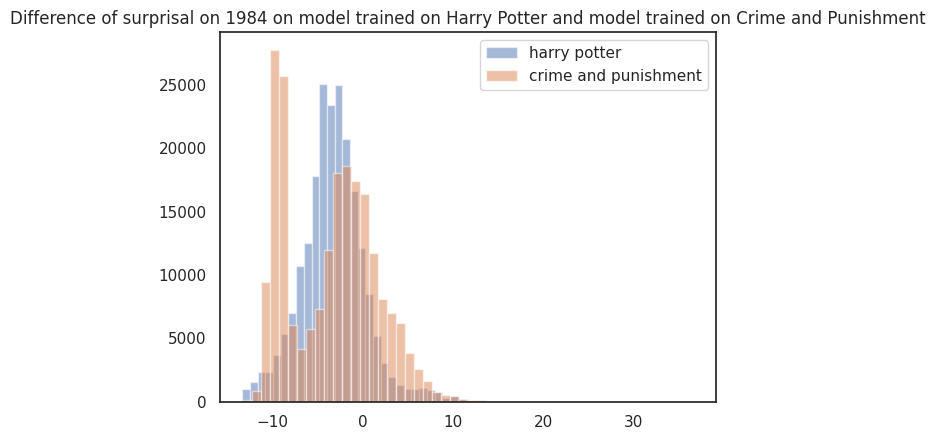

In [ ]:
plt.hist(hp_on_1984['surp'].values-b_1984_on_1984['surp'].values, bins=50, alpha=0.5, label='harry potter')
plt.hist(cp_on_1984['surp'].values-b_1984_on_1984['surp'].values, bins=50, alpha=0.5, label='crime and punishment')
plt.legend()
plt.title('Difference of surprisal on 1984 on model trained on Harry Potter and model trained on Crime and Punishment')
plt.show()

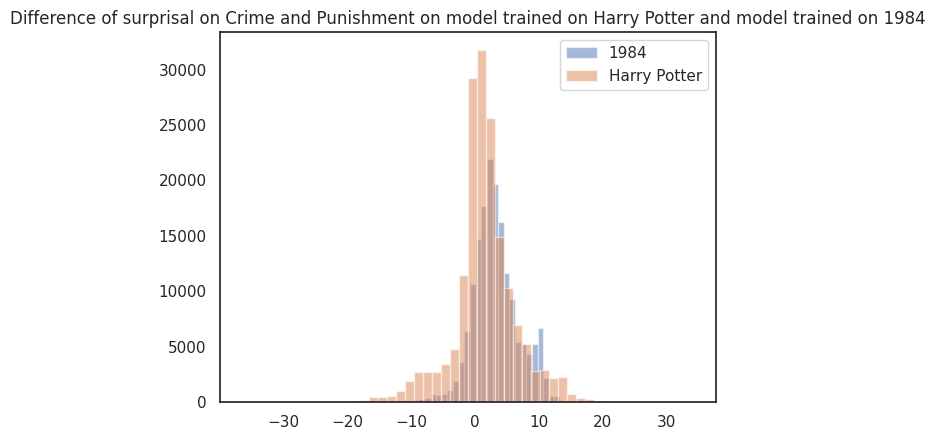

In [ ]:
plt.hist(b_1984_on_cp['surp'].values-cp_on_cp['surp'].values, bins=50, alpha=0.5, label='1984')
plt.hist(hp_on_cp['surp'].values-cp_on_cp['surp'].values, bins=50, alpha=0.5, label='Harry Potter')
plt.legend()
plt.title('Difference of surprisal on Crime and Punishment on model trained on Harry Potter and model trained on 1984')
plt.show()

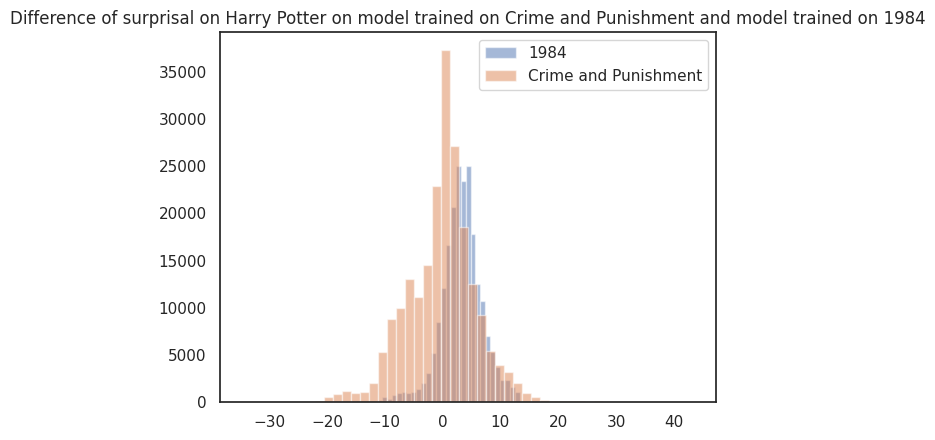

In [ ]:
plt.hist(b_1984_on_hp['surp'].values-hp_on_hp['surp'].values, bins=50, alpha=0.5, label='1984')
plt.hist(cp_on_hp['surp'].values-hp_on_hp['surp'].values, bins=50, alpha=0.5, label='Crime and Punishment')
plt.legend()
plt.title('Difference of surprisal on Harry Potter on model trained on Crime and Punishment and model trained on 1984')
plt.show()